In [1]:
import tensorflow as tf

import keras
from keras.models import load_model

import numpy as np
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# helpers vars for the notebook
already_trained = False
train_test_model = False

In [3]:
# The following code is just copied over from the baseline_cnn_notebook
# (with some modification)

class ModelParameters:

    def __init__(self,
                 training_data_path,
                 num_classes=28,
                 num_epochs=5,
                 batch_size=16,
                 image_rows=1708,
                 image_cols=1708,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 n_channels=3,
                 using_imagenet=False,
                 shuffle=False):
        
        self.training_data_path = training_data_path
        self.num_classes = num_classes
        # what does n_epochs mean? it seems we pass this into the "epochs"
        # parameter on the "fit_generator" method on our keras model
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.row_dimension = np.int(image_rows / row_scale_factor)
        self.col_dimension = np.int(image_cols / col_scale_factor)
        self.n_channels = n_channels
        self.shuffle = shuffle
        
        if using_imagenet:
            self.row_dimension = 224
            self.col_dimension = 224
            self.n_channels = 3


class ImagePreprocessor:

    def __init__(self, modelParameters):
        self.image_path = modelParameters.training_data_path
        self.n_channels = modelParameters.n_channels
        self.row_dimension = modelParameters.row_dimension
        self.col_dimension = modelParameters.col_dimension

    def preprocess(self, image):
        image = cv2.resize(image, (self.row_dimension, self.col_dimension))
        # image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        image = np.true_divide(image, 255)
        return image

    def load_image(self, image_id):
        image = cv2.imread(self.image_path + image_id + '.jpg')
        if self.n_channels == 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert Color to Greyscalle (1 channel)
            
        return image

class ImageBatchGenerator(keras.utils.Sequence):
    
    def __init__(self, image_ids, dataframe, model_params, image_processor):
        '''
        Writing a child implementation of keras.utils.Sequence will help us
        manage our batches of data.
        Each sequence must implement __len__ and __getitem__
        This structure guarantees that the network will only train once on each
        sample per epoch which is not the case with generators.
        
        We can use this class to instantiate training and validation generators
        that we can pass into our keras model like:
        
        training_generator = ImageBatchLoader(...)
        validation_generator = ImageBatchLoader(...)
        model.set_generators(training_generator, validation_generator)
        '''
        self.image_ids = image_ids
        self.dataframe = dataframe

        # Helper classes
        self._imageProcessor = image_processor

        # Training parameters
        self.batch_size = model_params.batch_size
        self.dimensions = (model_params.row_dimension, model_params.col_dimension)
        self.n_channels = model_params.n_channels
        self.shuffle = model_params.shuffle

        # Run on_epoch_end in _init_ to init our first image batch
        self.on_epoch_end()
        
    def on_epoch_end(self):
        '''
        Tensorflow will run this method at the end of each epoch
        So this is where we will modify our batch.
        '''
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        # Denotes the number of batchs per epoch
        return int(np.floor(len(self.image_ids) / self.batch_size))
            
    def __getitem__(self, index):
        # Get this batches indexes
        indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]

        # Get cooresponding image Ids
        batch_image_ids = [self.image_ids[i] for i in indexes]

        # Generate one batch of data
        X, y = self.__generator(batch_image_ids)
        
        return X, y
    
    def __generator(self, batch_image_ids):

        def get_target_class(imageid):
            # .loc will lookup the row where the passed in statement is true
            target = self.dataframe.loc[self.dataframe.imageId == imageid]
            target = target.lesion.values[0]
            return target

        X = np.empty((self.batch_size, *self.dimensions, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        

        for index, imageid in enumerate(batch_image_ids):
            image = self._imageProcessor.load_image(imageid)
            image = self._imageProcessor.preprocess(image)

            X[index] = image
            y[index] = get_target_class(imageid)

        return X, y


class PredictGenerator:

    def __init__(self, image_ids, image_processor, image_path):
        self.image_processor = image_processor
        self.image_processor.image_path = image_path
        self.image_ids = image_ids

    def predict(self, model):
        
        y = np.empty(shape=(len(self.image_ids)))
        
        for n in range(len(self.image_ids)):
            image = self.image_processor.load_image(self.image_ids[n])
            image = self.image_processor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        
        return y

In [4]:
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D, Conv2D
from keras.optimizers import SGD
from keras.models import Model
from keras.applications import DenseNet121

class GAIN_Model:
    
    def __init__(self, model_params):
        self.img_rows = model_params.row_dimension
        self.img_cols = model_params.col_dimension
        self.n_channels = model_params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.num_epochs = model_params.num_epochs
        self.metrics = ['accuracy']
        
    def get_densenet(self):
        return DenseNet121(
            include_top=False, 
            weights='imagenet')
        
    def build_model(self):
        # Step 1
        # Get DenseNet model
        base_model = self.get_densenet()
        
        # Step 2
        # In order to get an attention mask, we need to replace the last layers 
        # in the DenseNet model with a GAP layer and fully connected softmax layer
        x = Conv2D(self.img_rows, (3, 3), activation="relu", padding="same")(base_model.layers[-3].output)
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
        x = Dense(1024,activation='relu')(x) #dense layer 2
        x = Dense(512,activation='relu')(x) #dense layer 3
        preds = Dense(1, activation="sigmoid")(x)
        
        self.model = Model(inputs=base_model.input, outputs=preds)
    
    def compile_model(self):
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=True)
        self.model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=self.metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
        
    def learn(self):
        return self.model.fit_generator(
            generator=self.training_generator,
            validation_data=self.validation_generator,
            epochs=self.num_epochs,
            use_multiprocessing=True,
            workers=8,
            verbose=1)

    def score(self):
        return self.model.evaluate_generator(
            generator=self.validation_generator,
            use_multiprocessing=True,
            workers=8)

    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y

    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)

    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

In [5]:
# Get the data

import pandas as pd

data = pd.read_csv("./lesion-csv.csv")
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# All we care about at this point is the id and class
train_df = train_df.drop(
    ["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

test_df = test_df.drop(
    ["Unnamed: 0", "Unnamed: 0.1", "teethNumbers", "description", "numberOfCanals", "date", "sequenceNumber"], axis=1)

partition = {
    "train": train_df.imageId.values,
    "validation": test_df.imageId.values,
}

In [6]:
# Setup params and generators for model

train_path = './lesion_images/all_images_processed/'

model_params = ModelParameters(
    train_path,
    num_epochs= 1 if train_test_model else 10,
    batch_size=16,
    image_rows=224,
    image_cols=224,
    row_scale_factor=1,
    col_scale_factor=1)

image_processor = ImagePreprocessor(model_params)

training_generator = ImageBatchGenerator(partition['train'], data, model_params, image_processor)
validation_generator = ImageBatchGenerator(partition['validation'], data, model_params, image_processor)
predict_generator = PredictGenerator(partition['validation'], image_processor, train_path)

In [7]:
if not already_trained:
    print("Training Model")
    gain = GAIN_Model(model_params)
    gain.build_model()
    gain.compile_model()
    gain.set_generators(training_generator, validation_generator)
    history = gain.learn()
    
    filename = "test_model.h5" if train_test_model else "attention_mask_model.h5"
    gain.save(filename)
    model = gain.model
    already_trained = True
else:
    print("Loading Model")
    filename = "test_model.h5" if train_test_model else "attention_mask_model.h5"
    model = load_model("./"+ filename)

Training Model
Epoch 1/10
70/70 [==============================] - 29s 408ms/step - loss: 0.6942 - acc: 0.4795 - val_loss: 0.6937 - val_acc: 0.4875
Epoch 2/10
70/70 [==============================] - 17s 244ms/step - loss: 0.6933 - acc: 0.4795 - val_loss: 0.6942 - val_acc: 0.4875
Epoch 3/10
70/70 [==============================] - 17s 241ms/step - loss: 0.6927 - acc: 0.5027 - val_loss: 0.6926 - val_acc: 0.4875
Epoch 4/10
70/70 [==============================] - 17s 244ms/step - loss: 0.6922 - acc: 0.5348 - val_loss: 0.6940 - val_acc: 0.4875
Epoch 5/10
70/70 [==============================] - 17s 248ms/step - loss: 0.6915 - acc: 0.5143 - val_loss: 0.6949 - val_acc: 0.4875
Epoch 6/10
70/70 [==============================] - 17s 245ms/step - loss: 0.6902 - acc: 0.5429 - val_loss: 0.6906 - val_acc: 0.5125
Epoch 7/10
Epoch 6/10
70/70 [==============================] - 17s 244ms/step - loss: 0.6894 - acc: 0.5393 - val_loss: 0.6902 - val_acc: 0.4781
Epoch 8/10
70/70 [=========================

In [8]:
for i in range(-10, -1):
    print(i, model.layers[i])

-10 <keras.layers.normalization.BatchNormalization object at 0x7f27209ccfd0>
-9 <keras.layers.core.Activation object at 0x7f2720909f98>
-8 <keras.layers.convolutional.Conv2D object at 0x7f27209385f8>
-7 <keras.layers.merge.Concatenate object at 0x7f2720886be0>
-6 <keras.layers.convolutional.Conv2D object at 0x7f27207f7b00>
-5 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f271b170860>
-4 <keras.layers.core.Dense object at 0x7f271b170940>
-3 <keras.layers.core.Dense object at 0x7f271b2fef60>
-2 <keras.layers.core.Dense object at 0x7f271b35bf60>


In [9]:
input_layer = model.layers[0].input
output_layer = model.layers[-1].output
output_weights = model.layers[-1].get_weights()[0]
last_conv_layer = model.layers[-7].output

# We need to that the dot product of the last conv layer, with something from the output
# classmap = keras.backend.dot(output_layer, last_conv_layer)

get_output = keras.backend.function([input_layer], [last_conv_layer, output_layer])

predictions [[0.4076074]]


/home/jordan/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


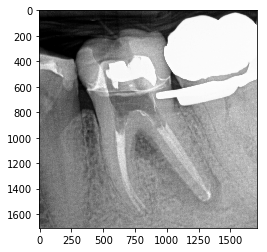

In [10]:
original_image = image_processor.load_image("0001-0")
X = image_processor.preprocess(original_image)
# reshape with batch size of 1
X = X.reshape(1, X.shape[0], X.shape[1], X.shape[2])
[conv_outputs, predictions] = get_output([X])
conv_outputs = conv_outputs[0, :, :, :] # what this do?

# cam is "class actiavtion map"
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])

for i, w in enumerate(output_weights[1, :]):
    np.append(cam, output_weights[:, 0][i] * conv_outputs[i, :, :])
    
print("predictions", predictions)

cam = np.true_divide(cam, np.max(cam))
cam = cv2.resize(cam, (original_image.shape[0], original_image.shape[1]))

plt.imshow(original_image)
plt.show()

/home/jordan/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


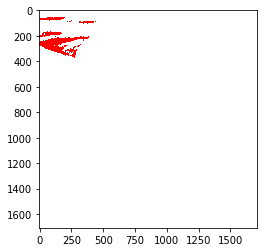

In [18]:
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap[np.where(cam < 0.8)] = 0
heatmap_img = heatmap*0.5 + original_image

plt.imshow(heatmap_img)

In [12]:
np_image = np.zeros(shape=(original_image.shape[0], original_image.shape[1], 3))

np_image[:,:] = original_image

In [13]:
np_image.shape

(1708, 1708, 3)

In [14]:
original_image.shape

(1708, 1708, 3)

In [15]:
cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY).shape

(1708, 1708)

In [24]:
output_weights.T.shape, last_conv_layer.shape

((1, 512),
 TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(1024)]))

In [28]:
thing = keras.backend.dot(model.layers[-1].kernel, last_conv_layer)

In [30]:
thing = tf.reshape(thing, (-1, 1, 224, 224))

In [33]:
testcmap = keras.backend.function([model.layers[0].input], [thing])

In [34]:
original_image = image_processor.load_image("0001-0")
X = image_processor.preprocess(original_image)
# reshape with batch size of 1
X = X.reshape(1, X.shape[0], X.shape[1], X.shape[2])
[thingsss] = testcmap([X])

InvalidArgumentError: Matrix size-incompatible: In[0]: [512,1], In[1]: [7,7168]
	 [[{{node MatMul_1}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_4/kernel/read, Reshape_4)]]
	 [[{{node Reshape_6/_7631}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4657_Reshape_6", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]